# Perform Ethnicity Classification by Images

# Dataset
The given dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. We will be using only 7000 of the 20,000 images. The dataset in this assignment is going to be used on the following task:

## Given the pixels of an image, perform ethnicity classification for the image using a fully connected neural network.


The dataset for this lab is already cleaned and provided in a CSV format for you with images included as pixel values.

The 4 columns contain the following information:


* **[age]** is an integer from 0 to 116, indicating the age. You can convert it to float for regression predictions
* **[gender]** is either 0 (male) or 1 (female)
* **[race]** is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
*  The 4th column contains the pixels of the images flattened to a single dimension. Each of the original image is of size 48x48 and the flattened image vector consists of 48x48 = 2304 pixel values.

In [2]:
!gdown https://drive.google.com/file/d/1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1_KRWsOhQNf6BZcdu4pg2JVy-lHo7_Cno
To: /content/DL_assignment1_dataset.csv
100% 199M/199M [00:00<00:00, 223MB/s]


In [3]:
import pandas
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('<== CUDA availability : ==>', use_cuda)

<== CUDA availability : ==> True


In [5]:
# Lets use pandas to load our data
df = pandas.read_csv("/content/DL_assignment1_dataset.csv")
df

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...
23700,99,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


### For this assignment we will be using fully connected neural networks and hence to keep things simple we will only use 7000 of the ~20000 images for quick training times.

### Please do not change the seed for the sampling of data points.

In [6]:
random_seed = 42
df_sampled = df.sample(n=7000, random_state=random_seed)
df_sampled.reset_index(drop=True, inplace=True)
df_sampled

,age,ethnicity,gender,pixels
0,49,1,1,31 32 28 27 34 38 37 40 47 51 52 57 72 93 118 ...
1,39,1,0,186 65 38 40 36 51 64 64 60 55 58 60 73 79 82 ...
2,8,4,0,20 23 35 34 45 65 69 72 79 92 106 115 134 148 ...
3,40,4,0,6 6 13 19 15 23 41 76 106 125 133 138 152 158 ...
4,27,0,0,31 31 29 51 98 136 162 175 176 178 178 179 184...
...,...,...,...,...
6995,49,3,0,128 130 131 131 132 134 134 140 72 43 102 77 1...
6996,28,1,1,28 22 19 23 16 22 19 31 64 81 88 96 108 120 13...
6997,32,3,1,221 229 227 200 166 115 146 198 186 184 178 15...
6998,41,0,0,58 61 76 58 83 71 74 90 71 112 77 91 111 135 1...


Let us take a look at an image. You will get an idea of how to process your data for your neural network.

The 4th column contains all the pixel values in a string for each image. Lets convert all the strings to arrays first.

In [7]:
def string_to_array(pixel_string):
    pixel_list = pixel_string.split()
    pixel_array = np.array([int(value) for value in pixel_list])
    return pixel_array

In [8]:
df_sampled['pixels'] = df_sampled['pixels'].apply(string_to_array)

In [9]:
df_sampled['pixels']

0       [31, 32, 28, 27, 34, 38, 37, 40, 47, 51, 52, 5...
1       [186, 65, 38, 40, 36, 51, 64, 64, 60, 55, 58, ...
2       [20, 23, 35, 34, 45, 65, 69, 72, 79, 92, 106, ...
3       [6, 6, 13, 19, 15, 23, 41, 76, 106, 125, 133, ...
4       [31, 31, 29, 51, 98, 136, 162, 175, 176, 178, ...
                              ...                        
6995    [128, 130, 131, 131, 132, 134, 134, 140, 72, 4...
6996    [28, 22, 19, 23, 16, 22, 19, 31, 64, 81, 88, 9...
6997    [221, 229, 227, 200, 166, 115, 146, 198, 186, ...
6998    [58, 61, 76, 58, 83, 71, 74, 90, 71, 112, 77, ...
6999    [19, 21, 20, 23, 33, 54, 90, 128, 149, 169, 17...
Name: pixels, Length: 7000, dtype: object

Our "pixels" column has been converted to arrays which we can now use as input features to our model

Lets show the first image of our dataset

Age: 28
Ethnicity: 3
Gender: 0


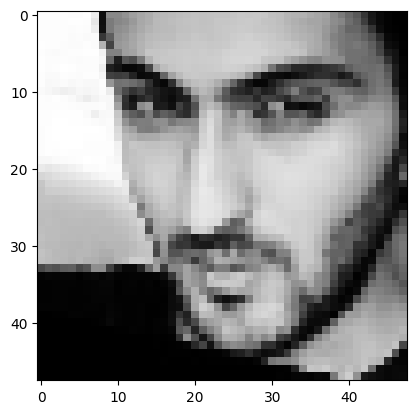

In [10]:
index = 30
first_image = df_sampled['pixels'][index]
image = first_image.reshape((48,48))
print("Age: "+str(df_sampled["age"][index])+"\nEthnicity: "+str(df_sampled["ethnicity"][index])+ "\nGender: "+str(df_sampled["gender"][index]))
plt.imshow(image,cmap="gray")

Uptill now, an initial processing has already been done using pandas in this starter code jupyter notebook. Hence you have a data frame ready for your assignment.

Please use the dataframe "df_sampled".

# You should consult the Lab 4 document provided to you for the tasks that are needed to be done for the successful completion. Grading rubricks are also mentioned in detail there.



In [11]:
# Write any further imports you need here
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dataset Creation

Drop the age and gender

In [12]:
target = df_sampled["ethnicity"]
input = df_sampled.drop(columns=["ethnicity","age","gender"])
print("Shape of Input", input.shape)
print("Shape of Output",target.shape)

Shape of Input (7000, 1)
Shape of Output (7000,)


Convert pixels to numpy

In [14]:
# Convert the 'pixels' column to NumPy arrays
X = np.array(input['pixels'].tolist())

# Convert the 'ethnicity' column to NumPy arrays
y = np.array(target)

Normalize the pixels colunm

In [15]:
X = X / 255.0

# Data Splitting

Split into train and test_and_validation

In [16]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
 X, y, test_size=0.3, random_state=42)

Splitting test_and_validation into test and validation sets

In [17]:
X_val, X_test, y_val, y_test = train_test_split(
 X_val_test, y_val_test, test_size=0.5, random_state=42)

In [18]:
print("Shape of Training Data",X_train.shape,y_train.shape)
print("Shape of Validation Data",X_val.shape,y_val.shape)
print("Shape of Testing Data",X_test.shape,y_test.shape)

Shape of Training Data (4900, 2304) (4900,)
Shape of Validation Data (1050, 2304) (1050,)
Shape of Testing Data (1050, 2304) (1050,)


# Part 2: Building a Fully Connected Neural Network

### Neural Network Architecture

Create and compile model

In [27]:
def ethnicity_classifier():
    model = keras.Sequential([
        layers.Input(shape=(2304,)),  # Input layer with 2304 neurons
        layers.Dense(256, activation='relu'),  # Hidden layer with 256 neurons and ReLU activation
        layers.Dense(512, activation='relu'),   # Hidden layer with 512 neurons and ReLU activation
        layers.Dropout(0.1),
        layers.Dense(512, activation='relu'),   # Hidden layer with 512 neurons and ReLU activation
        layers.Dense(5, activation='softmax')  # Output layer with 5 neurons (one for each class) and softmax activation
    ])
    return model
# Function to compile the model
def compile_model(model):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Print the model summary
    model.summary()


###Model Training

In [28]:
# Training model
def train_model(model, X_train, y_train, X_val, y_val, epochs=25, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    return history

In [29]:
# Function to plot accuracy and loss curves
def plot_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy vs. epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss vs. epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [22]:
# Function to evaluate the model on test data
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    return test_loss, test_accuracy

Creating and compiling the model

In [30]:
# Create and compile the model
model = ethnicity_classifier()
compile_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               590080    
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 986885 (3.76 MB)
Trainable params: 986885 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the model

In [31]:
history = train_model(model, X_train, y_train, X_val, y_val, epochs=25, batch_size=32)

Epoch 1/25
154/154 [==============================] - 2s 5ms/step - loss: 1.3872 - accuracy: 0.4547 - val_loss: 1.2847 - val_accuracy: 0.5267
Epoch 2/25
154/154 [==============================] - 1s 5ms/step - loss: 1.2485 - accuracy: 0.5186 - val_loss: 1.2365 - val_accuracy: 0.5571
Epoch 3/25
154/154 [==============================] - 1s 4ms/step - loss: 1.1065 - accuracy: 0.5812 - val_loss: 1.1331 - val_accuracy: 0.5819
Epoch 4/25
154/154 [==============================] - 1s 4ms/step - loss: 1.0421 - accuracy: 0.6184 - val_loss: 1.0186 - val_accuracy: 0.6219
Epoch 5/25
154/154 [==============================] - 1s 4ms/step - loss: 1.0304 - accuracy: 0.6198 - val_loss: 1.0950 - val_accuracy: 0.6010
Epoch 6/25
154/154 [==============================] - 1s 5ms/step - loss: 0.9875 - accuracy: 0.6369 - val_loss: 0.9439 - val_accuracy: 0.6676
Epoch 7/25
154/154 [==============================] - 1s 6ms/step - loss: 0.9538 - accuracy: 0.6594 - val_loss: 0.9852 - val_accuracy: 0.6333
Epoch 

### Performance Evaluation

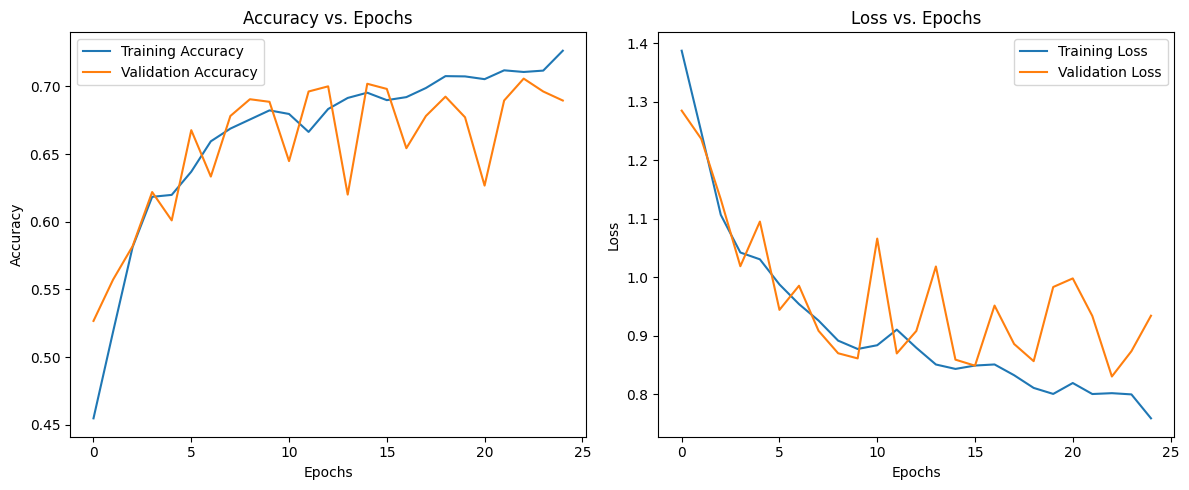

In [32]:
plot_curves(history)

# Part 3: Evaluation

Test Loss and Test Accuracy

In [33]:
test_loss, test_accuracy = evaluate_model(model, X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

33/33 [==============================] - 0s 2ms/step - loss: 0.9278 - accuracy: 0.6895
Test Loss: 0.9278, Test Accuracy: 0.6895


Function for Confusion Matrix

In [36]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["White", "Black", "Asian", "Indian", "Others"],
                yticklabels=["White", "Black", "Asian", "Indian", "Others"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Plotting matrix

33/33 [==============================] - 0s 2ms/step


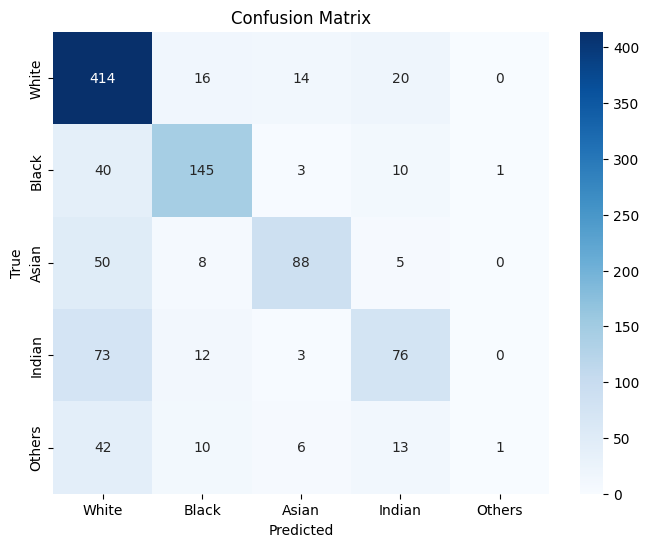

In [37]:
plot_confusion_matrix(model, X_test, y_test)